In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py 
from tqdm import tqdm

class Linear():
    def __init__(self, in_features, out_features, act=None, act_bkwd=None):
      self.W=np.random.randn(in_features,out_features)*np.sqrt(2/out_features)
      self.b=np.zeros(out_features)
      self.activation=act
      self.activation_bkwd=act_bkwd
    
    def __call__(self, x, *args, **kwargs):
        return x@self.W+self.b

class NumpyMLP():
  def __init__(self, train_file, test_file, activation='relu'):
    #PART a
    self.data={}
    self.act=activation
    with h5py.File(train_file, 'r') as hf:
        self.data['x_train']=hf['xdata'][:]
        self.data['x_valid']=self.data['x_train'][50000:]
        self.data['x_train']=self.data['x_train'][:50000]
        self.data['y_train']=hf['ydata'][:]
        self.data['y_valid']=self.data['y_train'][50000:]
        self.data['y_train']=self.data['y_train'][:50000]
    with h5py.File(test_file,'r') as hf:
        self.data['x_test']=hf['xdata'][:]
        self.data['y_test']=hf['ydata'][:]
    print('Train set shapes:', self.data['x_train'].shape,self.data['y_train'].shape)
    print('Valid set shapes:', self.data['x_valid'].shape, self.data['y_valid'].shape)
    print('Test set shapes:',self.data['x_test'].shape, self.data['y_test'].shape)
    
    #PART b & c 
    if activation=='relu':
      self.linear1=Linear(in_features=784, out_features=512, act=self.relu, act_bkwd=self.relu_backward)
      self.linear2=Linear(in_features=512,out_features=64, act=self.relu, act_bkwd=self.relu_backward)
      self.linear3=Linear(in_features=64, out_features=32, act=self.relu, act_bkwd=self.relu_backward)
      self.linear4=Linear(in_features=32, out_features=10)
    else:
      self.linear1=Linear(in_features=784, out_features=512, act=self.tanh, act_bkwd=self.tanh_backward)
      self.linear2=Linear(in_features=512,out_features=64, act=self.tanh, act_bkwd=self.tanh_backward)
      self.linear3=Linear(in_features=64, out_features=32, act=self.tanh, act_bkwd=self.tanh_backward)
      self.linear4=Linear(in_features=32, out_features=10)
  
  def relu(self, x):
    return np.clip(x,a_min=0,a_max=None)

  def relu_backward(self,x):
    x[x<=0]=0
    x[x>0]=1
    return x

  def tanh(self,x):
    return np.tanh(x)

  def tanh_backward(self, x):
    out = [1-np.tanh(sample)**2 for sample in x]
    return np.array(out)

  def softmax(self, x):
    out=[np.exp(sample)/np.sum(np.exp(sample)) for sample in x]
    return np.array(out)

  def save_weights(self, model_path):
    with h5py.File(model_path, 'w') as hf:
      hf.create_dataset('linear_1.weight', data=self.linear1.W)
      hf.create_dataset('linear_1.bias', data=self.linear1.b)
      hf.create_dataset('linear_2.weight', data=self.linear2.W)
      hf.create_dataset('linear_2.bias', data=self.linear2.b)
      hf.create_dataset('linear_3.weight', data=self.linear3.W)
      hf.create_dataset('linear_3.bias', data=self.linear3.b)
      hf.create_dataset('linear_4.weight', data=self.linear4.W)
      hf.create_dataset('linear_4.bias', data=self.linear4.b)
      hf.create_dataset('activation',data=self.act)

  def load_weights(self,model_path):
    with h5py.File(model_path,'r') as hf:
      self.linear1.W=hf['linear_1.weight'][:]
      self.linear1.b=hf['linear_1.bias'][:]
      self.linear2.W=hf['linear_2.weight'][:]
      self.linear2.b=hf['linear_2.bias'][:]
      self.linear3.W=hf['linear_3.weight'][:]
      self.linear3.b=hf['linear_3.bias'][:]
      self.linear4.W=hf['linear_4.weight'][:]
      self.linear4.b=hf['linear_4.bias'][:]
      if hf['activation']=='relu':
        self.linear1.activation, self.linear1.activation_bkwd=self.relu, self.relu_backward
        self.linear2.activation, self.linear2.activation_bkwd=self.relu, self.relu_backward
        self.linear3.activation, self.linear3.activation_bkwd=self.relu, self.relu_backward
        self.linear4.activation, self.linear4.activation_bkwd=self.relu, self.relu_backward
      else:
        self.linear1.activation, self.linear1.activation_bkwd=self.tanh, self.tanh_backward
        self.linear2.activation, self.linear2.activation_bkwd=self.tanh, self.tanh_backward
        self.linear3.activation, self.linear3.activation_bkwd=self.tanh, self.tanh_backward
        self.linear4.activation, self.linear4.activation_bkwd=self.tanh, self.tanh_backward
         
  def train(self, epochs, batch_size=50, lr=1e-3, save_path='model.hdf5'):
    losses=[]
    train_losses=[]
    valid_losses=[]
    train_accuracy=[]
    valid_accuracy=[]
    steps=[]
    best_val_acc=0.0
    for i in tqdm(range(epochs)):
      if i == int(epochs*0.5):
        lr=lr/2
      if i == int(epochs*0.78):
        lr=lr/2
      steps.append(lr)
      running_loss=0.0
      count=0
      for j in range(0, self.data['x_train'].shape[0], batch_size):
        x_batch=self.data['x_train'][j:j+batch_size]
        x_batch=x_batch/255.
        noise=np.random.normal(0,0.05,x_batch.shape)
        x_batch=x_batch+noise
        y_batch=self.data['y_train'][j:j+batch_size]
        
        h_1=self.linear1(x_batch)
        a_1=self.linear1.activation(h_1)
        noise=np.random.normal(0,0.05,a_1.shape)
        a_1+=noise
        h_2=self.linear2(a_1)
        a_2=self.linear2.activation(h_2)
        noise=np.random.normal(0,0.05,a_2.shape)
        a_2+=noise
        h_3=self.linear3(a_2)
        a_3=self.linear3.activation(h_3)
        noise=np.random.normal(0,0.05,a_3.shape)
        # a_3+=noise
        h_4=self.linear4(a_3)
        a_4=self.softmax(h_4)

        loss=-np.sum(y_batch*np.log(a_4))/y_batch.shape[0]
        running_loss+=loss
        count+=batch_size
        
        delta_L = (a_4-y_batch)/x_batch.shape[0]
        da_3 = self.linear3.activation_bkwd(h_3)
        da_2 = self.linear2.activation_bkwd(h_2)
        da_1 = self.linear1.activation_bkwd(h_1)
        
        delta_3 = np.multiply(da_3, delta_L@self.linear4.W.T)
        delta_2 = np.multiply(da_2,delta_3@self.linear3.W.T)
        delta_1 = np.multiply(da_1,delta_2@self.linear2.W.T)

        # print(np.multiply(delta_L, a_3).shape)
        # print(a_3.shape, y_batch.shape, delta_L.shape, a_3.shape, self.linear3.W.shape, a_2.shape, a_1.shape, delta_2.shape, self.linear2.W.shape)
        self.linear4.W = self.linear4.W - lr* (a_3.T@delta_L)/x_batch.shape[0]
        self.linear4.b = self.linear4.b - lr* np.average(delta_L, axis=0)

        self.linear3.W = self.linear3.W - lr * (a_2.T@delta_3)/x_batch.shape[0]
        self.linear3.b = self.linear3.b - lr * np.average(delta_3,axis=0)

        self.linear2.W = self.linear2.W - lr * (a_1.T@delta_2)/x_batch.shape[0]
        self.linear2.b = self.linear2.b - lr* np.average(delta_2,axis=0)

        self.linear1.W = self.linear1.W - lr * (x_batch.T@delta_1)/x_batch.shape[0]
        self.linear1.b = self.linear1.b - lr * np.average(delta_1,axis=0)
                
      losses.append(running_loss/count)
      y_pred_train=self.softmax(self.linear4(self.linear3.activation(self.linear3(self.linear2.activation(self.linear2(self.linear1.activation(self.linear1(self.data['x_train']/255.))))))))
      y_pred_logits=np.argmax(y_pred_train,axis=1)
      y_gt_logits=np.argmax(self.data['y_train'],axis=1)
      train_accuracy.append((y_pred_logits==y_gt_logits).sum()/y_gt_logits.shape[0])
      train_losses.append(-np.sum(self.data['y_train']*np.log(y_pred_train))/y_pred_train.shape[0])
      y_pred_valid=self.softmax(self.linear4(self.linear3.activation(self.linear3(self.linear2.activation(self.linear2(self.linear1.activation(self.linear1(self.data['x_valid']/255.))))))))      
      y_pred_valid_logits=np.argmax(y_pred_valid,axis=1)
      y_gt_valid_logits=np.argmax(self.data['y_valid'],axis=1)
      valid_losses.append(-np.sum(self.data['y_valid']*np.log(y_pred_valid))/y_pred_valid.shape[0])
      valid_accuracy.append((y_pred_valid_logits==y_gt_valid_logits).sum()/y_gt_valid_logits.shape[0])
      if valid_accuracy[-1]>best_val_acc:
        best_val_acc=valid_accuracy[-1]
        self.save_weights(save_path)
    return losses, train_losses, valid_losses, train_accuracy, valid_accuracy, steps



In [2]:
mlp=NumpyMLP('mnist_traindata.hdf5','mnist_testdata.hdf5', activation='tanh')
losses,train_losses, valid_losses, train_accuracy,valid_accuracy, lr_steps =mlp.train(epochs=50, lr=1e-2, save_path='model_tanh_1e-2.hdf5')
model_tanh_lr1e2=[losses,train_losses,valid_losses,train_accuracy, valid_accuracy, lr_steps]
valid_accuracy[-1]

  0%|          | 0/50 [00:00<?, ?it/s]

Train set shapes: (50000, 784) (50000, 10)
Valid set shapes: (10000, 784) (10000, 10)
Test set shapes: (10000, 784) (10000, 10)


100%|██████████| 50/50 [15:48<00:00, 18.98s/it]


0.9113

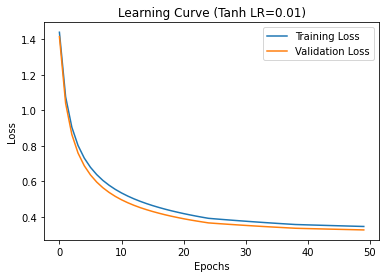

In [5]:
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.title('Learning Curve (Tanh LR=0.01)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

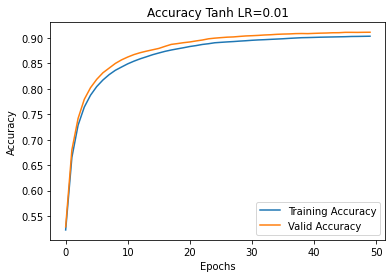

In [8]:
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(valid_accuracy, label='Valid Accuracy')
plt.title('Accuracy Tanh LR=0.01')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
valid_accuracy[-1]

0.9113

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [13]:
train_set=torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_set=torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader=torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [14]:
output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0, Loss 1.395633
Test Accuracy:0.654800
Epoch 1, Loss 1.127830
Test Accuracy:0.715300
Epoch 2, Loss 0.999274
Test Accuracy:0.748300
Epoch 3, Loss 0.919806
Test Accuracy:0.763400
Epoch 4, Loss 0.862425
Test Accuracy:0.781300
Epoch 5, Loss 0.818585
Test Accuracy:0.791000
Epoch 6, Loss 0.783801
Test Accuracy:0.794000
Epoch 7, Loss 0.755195
Test Accuracy:0.799700
Epoch 8, Loss 0.731126
Test Accuracy:0.814600
Epoch 9, Loss 0.710433
Test Accuracy:0.809400


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

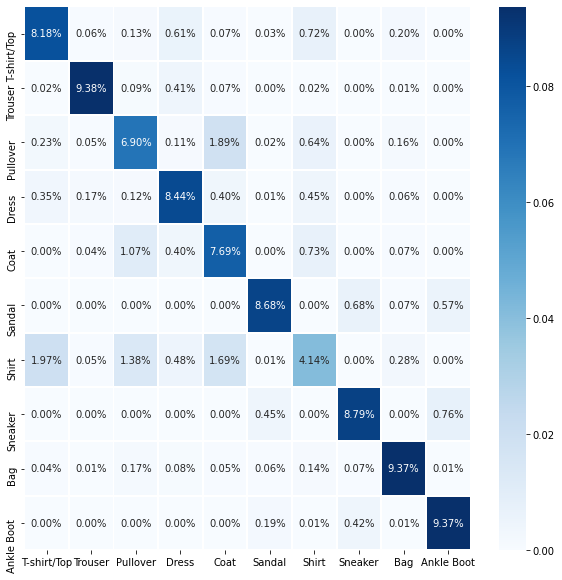

In [67]:
class MLP(nn.Module):
    def __init__(self, dropout_rate):
        super(MLP, self).__init__()
        self.net=nn.Sequential(
            nn.Linear(784,100),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(100,10)
        )

    def forward(self, x):
        x=x.view(100,-1)
        return self.net(x)

def train():
    mlp=MLP(dropout_rate=0.3)
    losses=[]
    running_loss=0.0
    counts=0
    criterion=nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(mlp.parameters(), lr=0.01)
    for i in range(10):
        for x_train, y_train in train_loader:
            optimizer.zero_grad()
            y_pred=mlp(x_train)
            loss=criterion(y_pred,y_train)
            l2_reg=torch.tensor(0.)
            lambda_reg=torch.tensor(0.0001)
            for param in mlp.parameters():
                l2_reg+=torch.norm(param)
            loss+=lambda_reg * l2_reg
            loss.backward()
            optimizer.step()
            running_loss+=loss.item()
            counts+=1
        losses.append(running_loss/counts)
        corrects=0
        batches=0
        preds=[]
        targets=[]
        for x_test,y_test in test_loader:
            with torch.no_grad():
                y_pred=mlp(x_test)
                preds.append(F.softmax(y_pred).max(1,keepdim=True)[1])
                targets.append(y_test.cpu())
                corrects+=F.softmax(y_pred).max(1,keepdim=True)[1].eq(y_test.view(-1,1)).sum().item()
            batches+=1
        plt.clf()
        plt.figure(figsize=(10,10))
        print('Epoch %d, Loss %f'%(i, running_loss/counts))
        print('Test Accuracy:%f'%(corrects/(batches*100)))
        targets_test=torch.cat(targets).numpy()
        preds_test=(torch.cat(preds)[:,-1]).numpy()
        cf_matrix=confusion_matrix(targets_test,preds_test)

        hm=sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True,
                    fmt='.2%', cmap='Blues', linewidths=.9, xticklabels=list(output_mapping.values()), yticklabels=list(output_mapping.values()))
        hm.get_figure().savefig('epoch_%d_confusion.png'%i)
    return cf_matrix, losses

cf_matrix, losses=train()

Class 0-T-shirt/Top most confused with: Shirt at a rate of ~1.97%
Class 1-Trouser most confused with: Dress at a rate of ~0.17%
Class 2-Pullover most confused with: Shirt at a rate of ~1.3800000000000001%
Class 3-Dress most confused with: T-shirt/Top at a rate of ~0.61%
Class 4-Coat most confused with: Pullover at a rate of ~1.8900000000000001%
Class 5-Sandal most confused with: Sneaker at a rate of ~0.45%
Class 6-Shirt most confused with: Coat at a rate of ~0.73%
Class 7-Sneaker most confused with: Sandal at a rate of ~0.68%
Class 8-Bag most confused with: Shirt at a rate of ~0.28%
Class 9-Ankle Boot most confused with: Sneaker at a rate of ~0.76%


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  # Remove the CWD from sys.path while we load stuff.


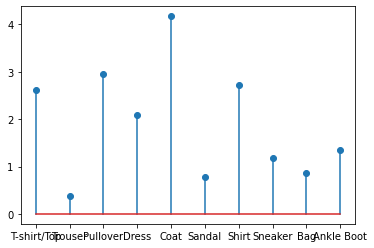

Most likely to be confused 2 classes:  Coat,Pullover


In [81]:
confusions_per_class=[]
for k,v in output_mapping.items():
  m=k
  col=cf_matrix[:,m]
  col=col.copy()
  col[m]=-1
  confusions_per_class.append(np.sum(col[col>0])/np.sum(cf_matrix)*100)
  col=col.tolist()
  print(f'Class {m}-{output_mapping[m]} most confused with: {output_mapping[np.argmax(col)]} at a rate of ~{np.max(col)*0.01}%')
plt.stem(confusions_per_class)
plt.xticks(range(10),output_mapping.values())
plt.show()
confusions_per_class=np.array(confusions_per_class).argsort()[-2:][::-1]
print('Most likely to be confused 2 classes: ',','.join([output_mapping[cls]for cls in confusions_per_class]))

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


In [83]:
train_set=torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_set=torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_loader=torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True)
test_loader=torch.utils.data.DataLoader(test_set, batch_size=100, shuffle=False)


In [84]:
output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat",
                 5: "Sandal",
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

In [85]:
class MLP_1(nn.Module):
    def __init__(self):
        super(MLP_1, self).__init__()
        self.linear1=nn.Linear(784,128)
        self.linear2=nn.Linear(128,10)

    def forward(self,x):
        x=self.linear1(x)
        x=F.relu(x)
        x=self.linear2(x)
        return x

class MLP_2(nn.Module):
    def __init__(self):
        super(MLP_2, self).__init__()
        self.linear1=nn.Linear(784,48)
        self.linear2=nn.Linear(48,10)

    def forward(self,x):
        x=self.linear1(x)
        x=F.relu(x)
        x=F.dropout(x,0.2)
        x=self.linear2(x)
        return x


Epoch 01, Iteration: 60000, Loss: 2.0460, Accuracy: 30.405%
Epoch 02, Iteration: 120000, Loss: 1.7835, Accuracy: 50.745%
Epoch 03, Iteration: 180000, Loss: 1.5386, Accuracy: 60.832%
Epoch 04, Iteration: 240000, Loss: 1.4006, Accuracy: 63.955%
Epoch 05, Iteration: 300000, Loss: 1.2380, Accuracy: 65.090%
Epoch 06, Iteration: 360000, Loss: 1.1454, Accuracy: 65.867%
Epoch 07, Iteration: 420000, Loss: 1.0141, Accuracy: 66.668%
Epoch 08, Iteration: 480000, Loss: 0.9068, Accuracy: 67.488%
Epoch 09, Iteration: 540000, Loss: 0.9261, Accuracy: 68.390%
Epoch 10, Iteration: 600000, Loss: 0.8343, Accuracy: 69.120%
Epoch 11, Iteration: 660000, Loss: 0.9578, Accuracy: 70.153%
Epoch 12, Iteration: 720000, Loss: 0.8040, Accuracy: 71.115%
Epoch 13, Iteration: 780000, Loss: 0.8429, Accuracy: 71.982%
Epoch 14, Iteration: 840000, Loss: 0.6328, Accuracy: 72.852%
Epoch 15, Iteration: 900000, Loss: 0.7510, Accuracy: 73.428%
Epoch 16, Iteration: 960000, Loss: 0.7368, Accuracy: 74.207%
Epoch 17, Iteration: 1020

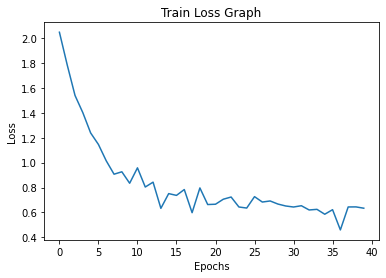

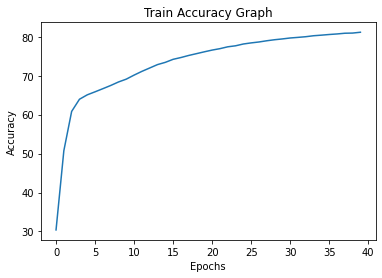

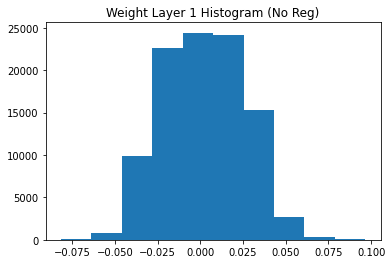

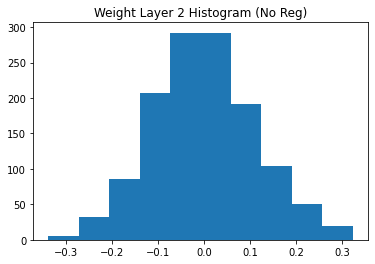

In [99]:
def setting_1():
    mlp_1 = MLP_1()
    mlp_1 = mlp_1.cuda()
    count = 0
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(mlp_1.parameters(), lr=1e-3)
    losses = []
    accuracy = []
    for epoch in range(40):
        correct = 0
        for images, labels in train_loader:
            optimizer.zero_grad()
            count += labels.size(0)
            input = images.view(-1, 28 * 28)
            input=input.to('cuda')
            outputs = mlp_1.forward(input)
            labels=labels.to('cuda')
            # for param in mlp_1.parameters():
            #     # print(param)
            #     l2_regularization+=torch.norm(param,2)**2
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizer.step()
            predictions = torch.max(outputs, 1)[1]
            correct += (predictions.cpu() == labels.cpu()).sum().numpy()
        losses.append(loss.data)
        accuracy.append(100 * correct / len(train_loader.dataset))
        print(
            f'Epoch {epoch + 1:02d}, Iteration: {count:5d}, Loss: {loss.data:.4f}, Accuracy: {100 * correct / len(train_loader.dataset):2.3f}%')

    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Loss Graph')
    plt.show()
    plt.figure()
    plt.plot(accuracy)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train Accuracy Graph')
    plt.show()
    plt.figure()

    plt.hist(mlp_1.linear1.weight.cpu().detach().numpy().T.flatten())
    plt.title('Weight Layer 1 Histogram (No Reg)')
    plt.show()
    plt.figure()
    plt.hist(mlp_1.linear2.weight.cpu().detach().numpy().T.flatten())
    plt.title('Weight Layer 2 Histogram (No Reg)')
    plt.show()
    return mlp_1
mlp_1=setting_1()

Epoch 01, Iteration:   600, Loss: 2.0905, Accuracy: 26.408%
Epoch 02, Iteration:  1200, Loss: 1.8492, Accuracy: 46.372%
Epoch 03, Iteration:  1800, Loss: 1.6025, Accuracy: 53.710%
Epoch 04, Iteration:  2400, Loss: 1.4805, Accuracy: 57.138%
Epoch 05, Iteration:  3000, Loss: 1.2089, Accuracy: 59.028%
Epoch 06, Iteration:  3600, Loss: 1.2353, Accuracy: 60.515%
Epoch 07, Iteration:  4200, Loss: 1.1331, Accuracy: 61.690%
Epoch 08, Iteration:  4800, Loss: 0.9938, Accuracy: 62.582%
Epoch 09, Iteration:  5400, Loss: 1.1297, Accuracy: 63.822%
Epoch 10, Iteration:  6000, Loss: 1.0708, Accuracy: 64.712%
Epoch 11, Iteration:  6600, Loss: 0.9449, Accuracy: 65.512%
Epoch 12, Iteration:  7200, Loss: 1.1306, Accuracy: 66.250%
Epoch 13, Iteration:  7800, Loss: 0.8580, Accuracy: 66.910%
Epoch 14, Iteration:  8400, Loss: 0.8883, Accuracy: 67.632%
Epoch 15, Iteration:  9000, Loss: 0.8855, Accuracy: 68.322%
Epoch 16, Iteration:  9600, Loss: 0.8757, Accuracy: 68.832%
Epoch 17, Iteration: 10200, Loss: 0.7388

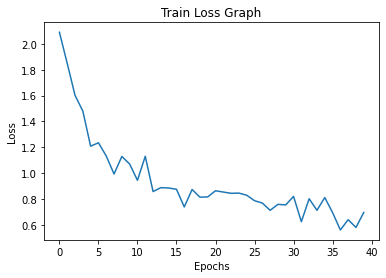

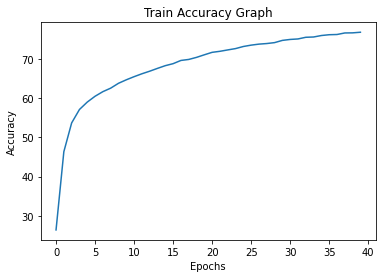

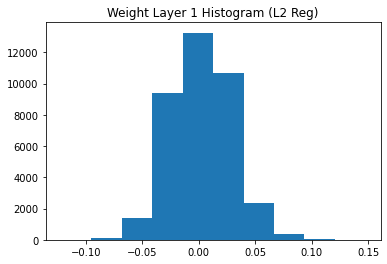

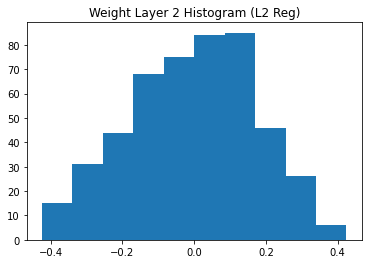

In [100]:
def setting_2():
  mlp_2 = MLP_2()
  mlp_2 = mlp_2.cuda()
  count = 0
  loss_func = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(mlp_2.parameters(), lr=1e-3)
  losses = []
  accuracy = []
  for epoch in range(40):
      correct = 0
      for images, labels in train_loader:
          optimizer.zero_grad()
          count += 1
          input = images.view(-1, 28 * 28)
          input = input.to('cuda')
          labels = labels.to('cuda')
          l2_regularization = torch.tensor(0.)
          l2_regularization = l2_regularization.to('cuda')

          outputs = mlp_2.forward(input)

          for param in mlp_2.parameters():
              l2_regularization+=torch.norm(param)
          loss = loss_func(outputs, labels)+0.0001*l2_regularization
          loss.backward()
          optimizer.step()
          predictions = torch.max(outputs, 1)[1]
          correct += (predictions.cpu() == labels.cpu()).sum().numpy()
      losses.append(loss.data)
      accuracy.append(100 * correct / len(train_loader.dataset))
      print(
          f'Epoch {epoch + 1:02d}, Iteration: {count:5d}, Loss: {loss.data:.4f}, Accuracy: {100 * correct / len(train_loader.dataset):2.3f}%')

  plt.plot(losses)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Train Loss Graph')
  plt.show()
  plt.figure()
  plt.plot(accuracy)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Train Accuracy Graph')
  plt.show()
  plt.figure()

  plt.hist(mlp_2.linear1.weight.cpu().detach().numpy().T.flatten())
  plt.title('Weight Layer 1 Histogram (L2 Reg)')
  plt.show()
  plt.figure()
  plt.hist(mlp_2.linear2.weight.cpu().detach().numpy().T.flatten())
  plt.title('Weight Layer 2 Histogram (L2 Reg)')
  plt.show()
  return mlp_2
mlp_2=setting_2()

In [105]:
print(torch.max(mlp_1.linear1.weight), torch.min(mlp_1.linear1.weight))
print(torch.max(mlp_1.linear2.weight), torch.min(mlp_1.linear2.weight))

print(torch.max(mlp_2.linear1.weight), torch.min(mlp_2.linear1.weight))
print(torch.max(mlp_2.linear2.weight), torch.min(mlp_2.linear2.weight))


tensor(0.0965, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.0817, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.3232, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.3376, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.1474, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.1221, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.4243, device='cuda:0', grad_fn=<MaxBackward1>) tensor(-0.4241, device='cuda:0', grad_fn=<MinBackward1>)


With regularization we have a more spread out distribution of weights with a slightly larger range as compared to without regularization

In [106]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt

In [111]:
class BinaryMLP(nn.Module):
  def __init__(self):
    super(BinaryMLP, self).__init__()

    self.linear1=nn.Linear(20,20)
    self.linear2=nn.Linear(20,1)

  def forward(self, x):
    x=self.linear1(x)
    x=F.relu(x)
    x=self.linear2(x)
    return F.sigmoid(x)

In [124]:
def bin_mlp_train():
  mlp=BinaryMLP()
  data_file='binary_random_20fa.hdf5'
  with h5py.File(data_file,'r') as hf:
      human = hf['human'][:]
      machine = hf['machine'][:]
  x_data = np.vstack([human, machine])
  human_y=np.ones(5100).T
  machine_y=np.zeros(5100).T
  y_data=np.concatenate([human_y,machine_y])
  x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

  criterion=nn.BCELoss()
  optimizer=torch.optim.Adam(mlp.parameters(),lr=1e-2)

  running_loss=0.0
  count=0
  train_acc=[]
  valid_acc=[]
  for epoch in range(100):
      for i in range(int(x_train.shape[0]/16)):
          optimizer.zero_grad()
          x_batch=torch.Tensor(x_train[i:i+16])
          y_batch=torch.Tensor(y_train[i:i+16])

          y_pred=mlp(x_batch)

          loss=criterion(y_pred,y_batch)
          l2_regularization=torch.tensor(0.)
          for param in mlp.parameters():
              l2_regularization+=torch.norm(param)
          loss+=l2_regularization*0.000001
          loss.backward()
          optimizer.step()

          running_loss+=loss.item()
          count+=16
      with torch.no_grad():
          y_pred_train=mlp.forward(torch.Tensor(x_train))
          y_pred_valid=mlp.forward(torch.Tensor(x_valid))
          train_acc.append((1-zero_one_loss(((y_pred_train>0.5).float()*1).numpy(),y_train)))
          valid_acc.append((1-zero_one_loss(((y_pred_valid > 0.5).float() * 1).numpy(), y_valid)))
      print(f'Epoch: {epoch}, Loss:{(running_loss/count)}')
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(valid_acc, label='Validation Accuracy')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Correct classification probability')
  plt.show()
  plt.figure()
  plt.imshow(mlp.linear1.weight.detach().numpy())
  plt.show()
  plt.figure()
  plt.hist(mlp.linear1.weight.detach().numpy().flatten())
  plt.show()
  print(mlp.linear1.weight)
  print(mlp.linear1.bias)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1625: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch: 0, Loss:0.038529304924475795
Epoch: 1, Loss:0.03869761327080721
Epoch: 2, Loss:0.03755526756989508
Epoch: 3, Loss:0.03669944084705967
Epoch: 4, Loss:0.03563085684297131
Epoch: 5, Loss:0.03467326655198692
Epoch: 6, Loss:0.033993559366702536
Epoch: 7, Loss:0.033043669551547035
Epoch: 8, Loss:0.032124660276931616
Epoch: 9, Loss:0.031121533807805357
Epoch: 10, Loss:0.030130020855326678
Epoch: 11, Loss:0.02903176841401766
Epoch: 12, Loss:0.027943223668227244
Epoch: 13, Loss:0.02689874037328706
Epoch: 14, Loss:0.02586711547532259
Epoch: 15, Loss:0.02498042426724329
Epoch: 16, Loss:0.02416883238749428
Epoch: 17, Loss:0.02338703227674724
Epoch: 18, Loss:0.02259348782581761
Epoch: 19, Loss:0.02181438788480591
Epoch: 20, Loss:0.021138088346305057
Epoch: 21, Loss:0.020478921984234046
Epoch: 22, Loss:0.01984738749962493
Epoch: 23, Loss:0.019264172023684568
Epoch: 24, Loss:0.01971962249831082
Epoch: 25, Loss:0.019202052648186477
Epoch: 26, Loss:0.01966968823235709
Epoch: 27, Loss:0.019598922

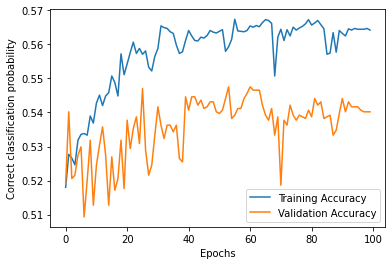

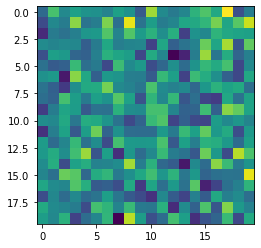

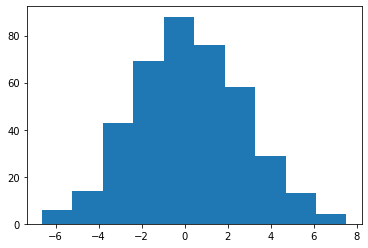

Parameter containing:
tensor([[-1.7784e+00,  3.3849e+00,  3.5262e-02,  1.4290e+00,  6.4269e-01,
          4.8544e-01, -3.1590e-01,  1.4108e+00,  5.6734e-01, -2.5673e+00,
          5.5195e+00,  1.5525e-01, -7.7338e-01, -1.3906e-01,  2.4925e+00,
          3.6050e+00,  1.9339e+00,  7.5153e+00, -3.1069e+00, -6.5941e-01],
        [-3.4136e+00, -1.9172e-02, -6.9320e-01,  5.0391e+00, -1.2051e+00,
         -6.2199e-01,  4.7036e+00, -1.4314e+00,  7.0638e+00, -1.2305e+00,
          1.2617e+00, -6.7304e-01, -1.7891e-01,  1.7217e+00,  1.9308e+00,
          2.6980e+00,  4.5890e+00,  1.6848e+00,  3.8292e+00,  6.3693e+00],
        [-4.9587e+00, -7.2335e-01, -1.3134e+00, -5.3611e-01,  7.8501e-01,
          1.0095e+00,  3.6690e+00, -3.1666e-01,  3.6923e+00,  1.1605e+00,
          2.4501e+00,  3.8232e-01,  2.2950e+00, -3.9629e+00,  5.6263e-01,
         -7.2389e-02,  2.5676e+00,  1.8449e+00,  1.6008e+00,  1.3939e+00],
        [ 1.9009e-01, -2.3236e-01,  2.2916e-02, -6.0692e-02, -2.3741e+00,
         -7.6

In [125]:
bin_mlp_train()

A majority of the weights are close to 0 which signifies sparse connections amongst features. Therefore by losing uncorrelated features we would be able to reduce dimensionality and get close to similar accuracy.

In [143]:
class CNN1D(nn.Module):
  def __init__(self):
    super(CNN1D,self).__init__()
    self.conv1=nn.Conv1d(20,10,3) #TODO 1: need to fix kernel shape
    self.conv2=nn.Conv1d(10,1,5)
  def forward(self, x):
    x=self.conv1(x)
    x=self.conv2(x)
    return F.sigmoid(x)



In [141]:
def cnn_1d_train():
  mlp=CNN1D()
  data_file='binary_random_20fa.hdf5'
  with h5py.File(data_file,'r') as hf:
      human = hf['human'][:]
      machine = hf['machine'][:]
  x_data = np.vstack([human, machine])
  human_y=np.ones(5100).T
  machine_y=np.zeros(5100).T
  y_data=np.concatenate([human_y,machine_y])
  x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

  criterion=nn.BCELoss()
  optimizer=torch.optim.Adam(mlp.parameters(),lr=1e-2)

  running_loss=0.0
  count=0
  train_acc=[]
  valid_acc=[]
  for epoch in range(100):
      for i in range(int(x_train.shape[0]/16)):
          optimizer.zero_grad()
          x_batch=torch.Tensor(x_train[i:i+16])
          y_batch=torch.Tensor(y_train[i:i+16])

          y_pred=mlp(x_batch.unsqueeze(-2))

          loss=criterion(y_pred,y_batch)
          l2_regularization=torch.tensor(0.)
          for param in mlp.parameters():
              l2_regularization+=torch.norm(param)
          loss+=l2_regularization*0.000001
          loss.backward()
          optimizer.step()

          running_loss+=loss.item()
          count+=16
      with torch.no_grad():
          y_pred_train=mlp.forward(torch.Tensor(x_train))
          y_pred_valid=mlp.forward(torch.Tensor(x_valid))
          train_acc.append((1-zero_one_loss(((y_pred_train>0.5).float()*1).numpy(),y_train)))
          valid_acc.append((1-zero_one_loss(((y_pred_valid > 0.5).float() * 1).numpy(), y_valid)))
      print(f'Epoch: {epoch}, Loss:{(running_loss/count)}')
  plt.plot(train_acc, label='Training Accuracy')
  plt.plot(valid_acc, label='Validation Accuracy')
  plt.legend()
  plt.xlabel('Epochs')
  plt.ylabel('Correct classification probability')
  plt.show()
  plt.figure()
  plt.imshow(mlp.linear1.weight.detach().numpy())
  plt.show()
  plt.figure()
  plt.hist(mlp.linear1.weight.detach().numpy().flatten())
  plt.show()
  print(mlp.linear1.weight)
  print(mlp.linear1.bias)

In [142]:
cnn_1d_train()

RuntimeError: ignored